In [1]:
"""
Complete Training Pipeline for Rare Species Classification
Using ConvNeXt-Small with 3-stage fine-tuning strategy
"""

import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
import random
import numpy as np
import pandas as pd
import tensorflow as tf
tf.config.optimizer.set_jit(False)  
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ConvNeXtSmall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime

2025-12-14 22:33:58.759312: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMG_SIZE = (224, 224)
BATCH_SIZE = 16

# Check GPU
print("\n" + "="*80)
print("GPU CHECK")
print("="*80)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ {len(gpus)} GPU(s) available")
    for gpu in gpus:
        print(f"  - {gpu}")
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("⚠ No GPU detected - training will be slow!")


GPU CHECK
✓ 1 GPU(s) available
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

df = pd.read_csv('../metadata.csv')
data_root_path = "/home/user/datasets/rare_species/"
df['full_path'] = df['file_path'].apply(lambda x: os.path.join(data_root_path, x))
df = df.dropna(subset=['file_path', 'family']).reset_index(drop=True)
df['exists'] = df['full_path'].apply(os.path.exists)
print(f"Number of missing files: {len(df[df['exists'] == False])}")
df = df[df['exists'] == True].reset_index(drop=True)
df = df.drop_duplicates().reset_index(drop=True)
df = df.drop_duplicates(subset='full_path').reset_index(drop=True)
print(f"Cleaned data: {len(df)} images")
print(f"Number of categories (families): {df['family'].nunique()}")
df['family'] = df['family'].astype(str)

# Stratified split: 80% train, 10% val, 10% test
train_val_df, test_df = train_test_split(
    df,
    test_size=0.10,
    stratify=df["family"],
    random_state=SEED
)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1111,  # 0.1111 * 0.9 = 0.10
    stratify=train_val_df["family"],
    random_state=SEED
)
print(f"Train: {len(train_df)}")
print(f"Val: {len(val_df)}")
print(f"Test: {len(test_df)}")


DATA PREPROCESSING
Number of missing files: 123
Cleaned data: 11860 images
Number of categories (families): 202
Train: 9488
Val: 1186
Test: 1186


In [4]:
print("\n" + "="*80)
print("BUILDING DATA GENERATORS")
print("="*80)

"""# ConvNeXt preprocessing
def preprocess_convnext(x):
    Normalize to [0, 1] for ConvNeXt
    return x / 255.0

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_convnext,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_convnext
)"""

# balazs: Modified to use built-in ConvNeXt preprocessing because it wasnt learning at all...
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess

train_datagen = ImageDataGenerator(
    preprocessing_function=convnext_preprocess,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=convnext_preprocess
)

train_ds = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='full_path',
    y_col='family',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_ds = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='full_path',
    y_col='family',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_ds = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='full_path',
    y_col='family',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Train batches: {len(train_ds)}")
print(f"Val batches: {len(val_ds)}")
print(f"Test batches: {len(test_ds)}")
print(f"Number of classes: {len(train_ds.class_indices)}")


BUILDING DATA GENERATORS
Found 9488 validated image filenames belonging to 202 classes.
Found 1186 validated image filenames belonging to 202 classes.
Found 1186 validated image filenames belonging to 202 classes.
Train batches: 593
Val batches: 75
Test batches: 75
Number of classes: 202


In [5]:
print("\n" + "="*80)
print("COMPUTING CLASS WEIGHTS")
print("="*80)

labels = train_ds.classes
weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(weights))
print(f"Class weights computed for {len(class_weights)} classes")
print(f"Weight range: {min(weights):.3f} to {max(weights):.3f}")


COMPUTING CLASS WEIGHTS
Class weights computed for 202 classes
Weight range: 0.197 to 2.135


In [6]:
def build_model(num_classes, trainable_backbone=False):
    """
    Create ConvNeXt-Small model with custom head

    Args:
        num_classes: Number of output classes
        trainable_backbone: Whether to make backbone trainable
    """
    print(f"\nBuilding model (backbone trainable: {trainable_backbone})")

    # Load pretrained ConvNeXt-Small
    base_model = ConvNeXtSmall(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        pooling=None
    )

    base_model.trainable = trainable_backbone

    # Build custom head
    inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    print(f"Total parameters: {model.count_params():,}")
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"Trainable parameters: {trainable_params:,}")

    return model

def unfreeze_top_layers(model, percentage=0.3):
    """
    Unfreeze top percentage of backbone layers

    Args:
        model: Keras model
        percentage: Percentage of layers to unfreeze (from the end)
    """
    base_model = model.layers[1]  # The ConvNeXt backbone
    total_layers = len(base_model.layers)
    unfreeze_from = int(total_layers * (1 - percentage))

    print(f"\nUnfreezing top {percentage*100}% of backbone layers")
    print(f"Total backbone layers: {total_layers}")
    print(f"Unfreezing from layer {unfreeze_from} onwards")

    base_model.trainable = True
    for layer in base_model.layers[:unfreeze_from]:
        layer.trainable = False

    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"Trainable parameters after unfreezing: {trainable_params:,}")


In [7]:
def get_callbacks(stage_name, patience=4):
    """Get training callbacks for a specific stage"""

    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

    callbacks = [
        # Save best model
        ModelCheckpoint(
            filepath=f'model_{stage_name}_best.keras',
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),

        # Reduce learning rate when stuck
        ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1,
            mode='max'
        ),

        # Early stopping
        EarlyStopping(
            monitor='val_accuracy',
            patience=patience,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),

        # TensorBoard logging
        TensorBoard(
            log_dir=f'logs/{stage_name}_{timestamp}',
            histogram_freq=0
        )
    ]

    return callbacks

In [8]:
    # Build model
    print("\n" + "="*80)
    print("MODEL ARCHITECTURE")
    print("="*80)
    num_classes = len(train_ds.class_indices)
    model = build_model(num_classes=num_classes, trainable_backbone=False)
    model.summary()


MODEL ARCHITECTURE

Building model (backbone trainable: False)


I0000 00:00:1765751652.357466   11747 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Total parameters: 49,954,090
Trainable parameters: 498,378


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_small (Functional)     │ (None, 7, 7, 768)      │    49,454,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 202)            │       103,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,954,090 (190.56 MB)

 Trainable params: 498,378 (1.90 MB)

 Non-trainable params: 49,455,712 (188.66 MB)

In [9]:
"""Stage 1: Train with frozen backbone"""
print("\n" + "="*80)
print("STAGE 1: Training with FROZEN backbone")
print("="*80)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=3e-4,
        weight_decay=1e-4
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_acc')]
)

# Train
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    class_weight=class_weights,
    callbacks=get_callbacks('stage1', patience=4),
    verbose=1
)

# Save
model.save('model_after_stage1.keras')
print(f"\nStage 1 COMPLETE! Model saved.")


STAGE 1: Training with FROZEN backbone
Epoch 1/8


2025-12-10 14:42:27.548021: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f0d5c0021c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-10 14:42:27.548084: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-12-10 14:42:28.778701: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-10 14:42:33.700810: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-10 14:42:39.333571: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_67', 16 bytes spill stores, 16 bytes spill loads

2025-12-10 14:42:41.442056: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:34

593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.0844 - loss: 5.1209 - top5_acc: 0.1848

2025-12-10 14:51:29.247457: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 16 bytes spill stores, 16 bytes spill loads

2025-12-10 14:51:30.442291: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 64 bytes spill stores, 64 bytes spill loads

2025-12-10 14:51:30.622576: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_67', 4 bytes spill stores, 4 bytes spill loads

2025-12-10 14:51:30.728646: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 64 bytes spill stores, 64 bytes spill loads

2025-12-10 14:51:31.113894: I external/local_xla/xla


Epoch 1: val_accuracy improved from None to 0.41906, saving model to model_stage1_best.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 583s 885ms/step - accuracy: 0.1778 - loss: 4.3371 - top5_acc: 0.3496 - val_accuracy: 0.4191 - val_loss: 2.5530 - val_top5_acc: 0.7243 - learning_rate: 3.0000e-04
Epoch 2/8
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.3910 - loss: 2.6875 - top5_acc: 0.6808
Epoch 2: val_accuracy improved from 0.41906 to 0.49916, saving model to model_stage1_best.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 514s 865ms/step - accuracy: 0.4186 - loss: 2.4892 - top5_acc: 0.7112 - val_accuracy: 0.4992 - val_loss: 1.9513 - val_top5_acc: 0.8103 - learning_rate: 3.0000e-04
Epoch 3/8
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.4983 - loss: 1.9144 - top5_acc: 0.7924
Epoch 3: val_accuracy improved from 0.49916 to 0.55312, saving model to model_stage1_best.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 549s 924ms/step - accuracy: 0.5080 - loss: 1.8596 - top5_acc: 0.8008 - val_accuracy: 0.5531

In [ ]:
"""Stage 2: Unfreeze top 30% of backbone"""
print("\n" + "="*80)
print("STAGE 2: Training with PARTIAL backbone unfreezing (top 30%)")
print("="*80)

model = tf.keras.models.load_model('model_after_stage1.keras') #balazs: switched it with next line

# Unfreeze top layers
unfreeze_top_layers(model, percentage=0.3)


# Compile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=1e-4,# balazs: it was too low didnt learn. was 1e-5
        weight_decay=1e-4
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_acc')]
)

# Train
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    callbacks=get_callbacks('stage2', patience=5),
    verbose=1
)

# Save
model.save('model_after_stage2.keras')
print(f"\nStage 2 COMPLETE! Model saved.")


STAGE 2: Training with PARTIAL backbone unfreezing (top 30%)

Unfreezing top 30.0% of backbone layers
Total backbone layers: 259
Unfreezing from layer 181 onwards
Trainable parameters after unfreezing: 25,566,666
Epoch 1/15


2025-12-10 16:06:40.922846: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f9414018830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-10 16:06:40.923192: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-12-10 16:06:41.859234: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-10 16:06:46.699871: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-10 16:06:52.485092: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 64 bytes spill stores, 64 bytes spill loads

2025-12-10 16:06:53.231441: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:34

593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.6899 - loss: 0.9215 - top5_acc: 0.9245

2025-12-10 16:16:02.236135: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_67', 16 bytes spill stores, 16 bytes spill loads

2025-12-10 16:16:02.498233: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13', 16 bytes spill stores, 16 bytes spill loads

2025-12-10 16:16:03.692467: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_67', 4 bytes spill stores, 4 bytes spill loads

2025-12-10 16:16:04.723217: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 64 bytes spill stores, 64 bytes spill loads

2025-12-10 16:16:05.260482: I external/local_xla/xl


Epoch 1: val_accuracy improved from None to 0.62226, saving model to model_stage2_best.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 609s 930ms/step - accuracy: 0.6812 - loss: 0.9455 - top5_acc: 0.9202 - val_accuracy: 0.6223 - val_loss: 1.3897 - val_top5_acc: 0.8853 - learning_rate: 1.0000e-04
Epoch 2/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.6956 - loss: 0.8747 - top5_acc: 0.9248
Epoch 2: val_accuracy improved from 0.62226 to 0.62901, saving model to model_stage2_best.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 455s 761ms/step - accuracy: 0.6897 - loss: 0.8754 - top5_acc: 0.9246 - val_accuracy: 0.6290 - val_loss: 1.3764 - val_top5_acc: 0.8879 - learning_rate: 1.0000e-04
Epoch 3/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.6921 - loss: 0.8560 - top5_acc: 0.9237
Epoch 3: val_accuracy did not improve from 0.62901
593/593 ━━━━━━━━━━━━━━━━━━━━ 419s 706ms/step - accuracy: 0.6935 - loss: 0.8553 - top5_acc: 0.9277 - val_accuracy: 0.6256 - val_loss: 1.3708 - val_top5_acc: 0.8862 

In [10]:
# Stage 3: Fine-tune all layers0
print("\n" + "="*80)
print("STAGE 3: Training with FULL backbone unfreezing")
print("="*80)

model = tf.keras.models.load_model('model_after_stage2.keras')

# balazs: added lot of things here because it was keep crashing so i had to adjust it for my gpu

# --- Mixed precision ---
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# --- Recreate generators with smaller batch size if needed ---
NEW_BATCH_SIZE = 4

train_ds_stage3 = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='full_path',
    y_col='family',
    target_size=IMG_SIZE,
    batch_size=NEW_BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_ds_stage3 = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='full_path',
    y_col='family',
    target_size=IMG_SIZE,
    batch_size=NEW_BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
"""
# Unfreeze all layers
base_model = model.layers[1]
base_model.trainable = True"""

# Unfreeze all layers but freeze BatchNorm layers
base_model = model.layers[1]
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")

# Compile with even lower learning rate
opt = tf.keras.optimizers.AdamW(
    learning_rate=1e-5,
    weight_decay=1e-5
)
opt = mixed_precision.LossScaleOptimizer(opt)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_acc')]
)

# Train
history3 = model.fit(
    train_ds_stage3,
    validation_data=val_ds_stage3,
    epochs=20,
    class_weight=class_weights,
    callbacks=get_callbacks('stage3', patience=5),
    verbose=1
)

# Save
model.save('model_after_stage3.keras')
print(f"\nStage 3 COMPLETE! Model saved.")



STAGE 3: Training with FULL backbone unfreezing
Found 9488 validated image filenames belonging to 202 classes.
Found 1186 validated image filenames belonging to 202 classes.
Trainable parameters: 48,397,194
Epoch 1/10


2025-12-10 23:44:16.310624: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f20e0006e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-10 23:44:16.310723: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-12-10 23:44:17.574275: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-10 23:44:31.175575: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-10 23:44:41.110240: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13', 4 bytes spill stores, 4 bytes spill loads

2025-12-10 23:44:41.616222: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346]

2372/2372 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8447 - loss: 0.4167 - top5_acc: 0.9690

2025-12-10 23:53:25.628381: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_67', 16 bytes spill stores, 16 bytes spill loads

2025-12-10 23:53:26.470727: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 64 bytes spill stores, 64 bytes spill loads

2025-12-10 23:53:26.546802: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 64 bytes spill stores, 64 bytes spill loads

2025-12-10 23:53:26.555769: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 16 bytes spill stores, 16 bytes spill loads

2025-12-10 23:53:26.765302: I external/local_xla/x


Epoch 1: val_accuracy improved from None to 0.74789, saving model to model_stage3_best.keras
2372/2372 ━━━━━━━━━━━━━━━━━━━━ 638s 207ms/step - accuracy: 0.8491 - loss: 0.4029 - top5_acc: 0.9727 - val_accuracy: 0.7479 - val_loss: 1.0769 - val_top5_acc: 0.9216 - learning_rate: 1.0000e-05
Epoch 2/10
2372/2372 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8617 - loss: 0.3690 - top5_acc: 0.9764
Epoch 2: val_accuracy improved from 0.74789 to 0.74874, saving model to model_stage3_best.keras
2372/2372 ━━━━━━━━━━━━━━━━━━━━ 472s 199ms/step - accuracy: 0.8553 - loss: 0.3765 - top5_acc: 0.9742 - val_accuracy: 0.7487 - val_loss: 1.0657 - val_top5_acc: 0.9250 - learning_rate: 1.0000e-05
Epoch 3/10
2372/2372 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8653 - loss: 0.3561 - top5_acc: 0.9758
Epoch 3: val_accuracy improved from 0.74874 to 0.75211, saving model to model_stage3_best.keras
2372/2372 ━━━━━━━━━━━━━━━━━━━━ 474s 199ms/step - accuracy: 0.8641 - loss: 0.3507 - top5_acc: 0.9763 - val_accu

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def error_analysis(model, test_ds_eval, class_indices, normalize=True, top_k=15, save_prefix="test"):
    print("\n" + "="*80)
    print("ERROR ANALYSIS")
    print("="*80)

    test_ds_eval.reset()
    y_pred_proba = model.predict(test_ds_eval, verbose=1)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = test_ds_eval.classes

    idx_to_class = {v: k for k, v in class_indices.items()}
    class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))

    if normalize:
        cm_plot = cm.astype("float") / np.maximum(cm.sum(axis=1, keepdims=True), 1)
        title = "Confusion Matrix (row-normalized)"
    else:
        cm_plot = cm
        title = "Confusion Matrix (counts)"

    # plot (sok classnál ne rakj tick labelt)
    plt.figure(figsize=(12, 10))
    plt.imshow(cm_plot)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    plt.savefig(f"{save_prefix}_confusion_matrix.png", dpi=200)
    plt.show()

    # report
    report = classification_report(
        y_true, y_pred,
        target_names=class_names,
        digits=4,
        zero_division=0
    )
    print("\nClassification report:")
    print(report)

    # top confused pairs
    cm_off = cm.copy()
    np.fill_diagonal(cm_off, 0)
    pairs = []
    for i in range(cm_off.shape[0]):
        for j in range(cm_off.shape[1]):
            if cm_off[i, j] > 0:
                pairs.append((cm_off[i, j], class_names[i], class_names[j]))
    pairs.sort(reverse=True, key=lambda x: x[0])

    print(f"\nTop {top_k} confusions (True -> Pred, count):")
    for cnt, t, p in pairs[:top_k]:
        print(f"  {t} -> {p}: {cnt}")

    return cm


Found 1186 validated image filenames belonging to 202 classes.

ERROR ANALYSIS


2025-12-14 22:35:50.823192: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f03000042d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-14 22:35:50.823281: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-12-14 22:35:51.023566: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-14 22:35:51.773921: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-14 22:35:54.815235: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13', 4 bytes spill stores, 4 bytes spill loads

2025-12-14 22:35:55.020507: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346]

  2/593 ━━━━━━━━━━━━━━━━━━━━ 47s 81ms/step   

I0000 00:00:1765751765.705735   11912 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


175/593 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step

/home/user/tf_gpu_test/.venv/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


593/593 ━━━━━━━━━━━━━━━━━━━━ 49s 52ms/step


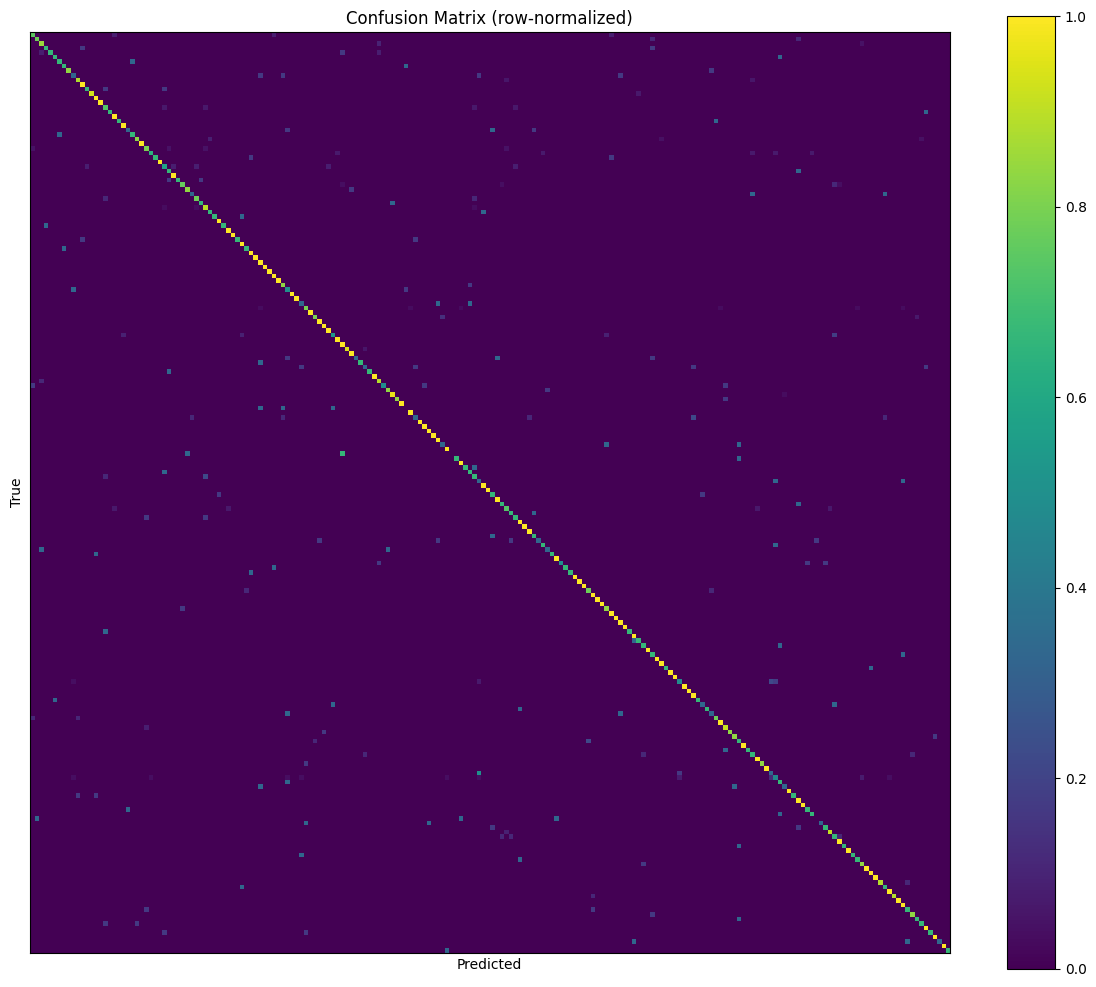


Classification report:
                   precision    recall  f1-score   support

     accipitridae     0.7500    0.7500    0.7500        12
    acipenseridae     0.8750    0.7778    0.8235         9
      acroporidae     0.8500    0.8500    0.8500        20
         agamidae     0.6667    0.6667    0.6667         6
      agariciidae     1.0000    0.6667    0.8000        12
        albulidae     0.6667    0.6667    0.6667         3
      alcedinidae     0.6667    0.6667    0.6667         3
    alligatoridae     0.6667    0.6667    0.6667         3
        alopiidae     1.0000    0.8333    0.9091         6
   ambystomatidae     0.3333    0.3333    0.3333         6
         anatidae     0.8824    0.8824    0.8824        17
         anguidae     0.7500    1.0000    0.8571         6
          aotidae     0.8000    0.6667    0.7273         6
           apidae     1.0000    0.9333    0.9655        15
         ardeidae     0.7500    1.0000    0.8571         6
   arthroleptidae     1.0000   

In [ ]:
# --- Load best model ONCE ---
model = tf.keras.models.load_model('model_stage3_best.keras')

# --- SMALL-BATCH EVAL GENERATOR ---
EVAL_BS = 2
test_ds_eval = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='full_path',
    y_col='family',
    target_size=IMG_SIZE,
    batch_size=EVAL_BS,
    class_mode='categorical',
    shuffle=False
)

# Error analysis
cm = error_analysis(
    model,
    test_ds_eval,
    class_indices=test_ds_eval.class_indices,
    normalize=True,
    top_k=15,
    save_prefix="test"
)
